In [1]:
import os
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['image.cmap'] = 'gray' # grayscale looks better

from IPython.display import Image, display, SVG, clear_output, HTML

import skimage.io
import skimage.color
import torch_geometric.data
import torch_geometric.utils 

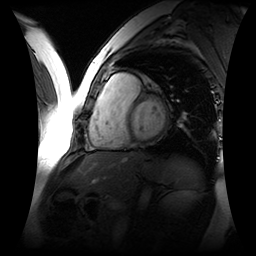

In [2]:
image_file = "data/train/images/image_0001.png"
image = skimage.io.imread(image_file)
display(Image(image_file))

In [3]:
class ImageGrid(object):
    def __init__(self, array=None, diff_edge=False):
        """[summary]

        Args:
            array ([numpy array], optional): [H W C=1,3 tensor]. Defaults to None.
            diff_edge (bool, optional): [description]. Defaults to False.
        """
        self.reset()
        self.set_array(array, diff_edge=diff_edge)

    def reset(self):
        self.height = 0
        self.width = 0
        self.array = None
        self.graph = None

    def set_array(self, array, diff_edge=False):
        self.reset()
        # if array.ndim == 3 and array.shape[2] == 3:
        #     array = skimage.color.rgb2gray(array)
        self.array = array if array.ndim == 3 else np.expand_dims(array, axis=2)
        height, width = array.shape[:2]
        self.set_shape(height, width)

        # Create the graph
        self.graph = nx.grid_2d_graph(self.height, self.width)
        self.set_nodes(weight=None)
        self.set_edges(weight=None, diff_edge=diff_edge)
        return self.graph

    # def set_image(self, image):
    #     return self.set_array(image, diff_edge=False)
    
    # def set_label(self, label):
    #     return self.set_array(label, diff_edge=True)
    
    def set_shape(self, height, width):
        self.height = height
        self.width = width

    def set_edges(self, weight=None, diff_edge=True):
        for e, edge in enumerate(self.graph.edges):
            self.graph.edges[edge]['weight'] = 0.5

        self.graph.add_edges_from([
            ((x, y), (x+1, y+1))
            for x in range(self.width-1)
            for y in range(self.height-1)
        ] + [
            ((x+1, y), (x, y+1))
            for x in range(self.width-1)
            for y in range(self.height-1)
        ], weight=0.5)

        if diff_edge:
            for e, edge in enumerate(self.graph.edges):
                self.graph.edges[edge]['weight'] = abs(self.array[edge[0]] - self.array[edge[1]]) 

    def set_nodes(self, weight=None):
        for n, node in enumerate(self.graph.nodes):
            y = n // self.width
            x = n % self.width
            self.graph.nodes[node]['weight'] = self.array[y,x,:] if weight is None else weight

# image_grid = ImageGrid(array=image[:28, :28].copy())
image_grid = ImageGrid(array=(image.copy()) / 255)
print(len(image_grid.graph.nodes))
print(len(image_grid.graph.edges))

G = image_grid.graph
data = torch_geometric.utils.from_networkx(G, 
    group_node_attrs=['weight'],
    group_edge_attrs=['weight'])
data

65536
260610


Data(edge_index=[2, 521220], x=[65536, 1], edge_attr=[521220, 1])

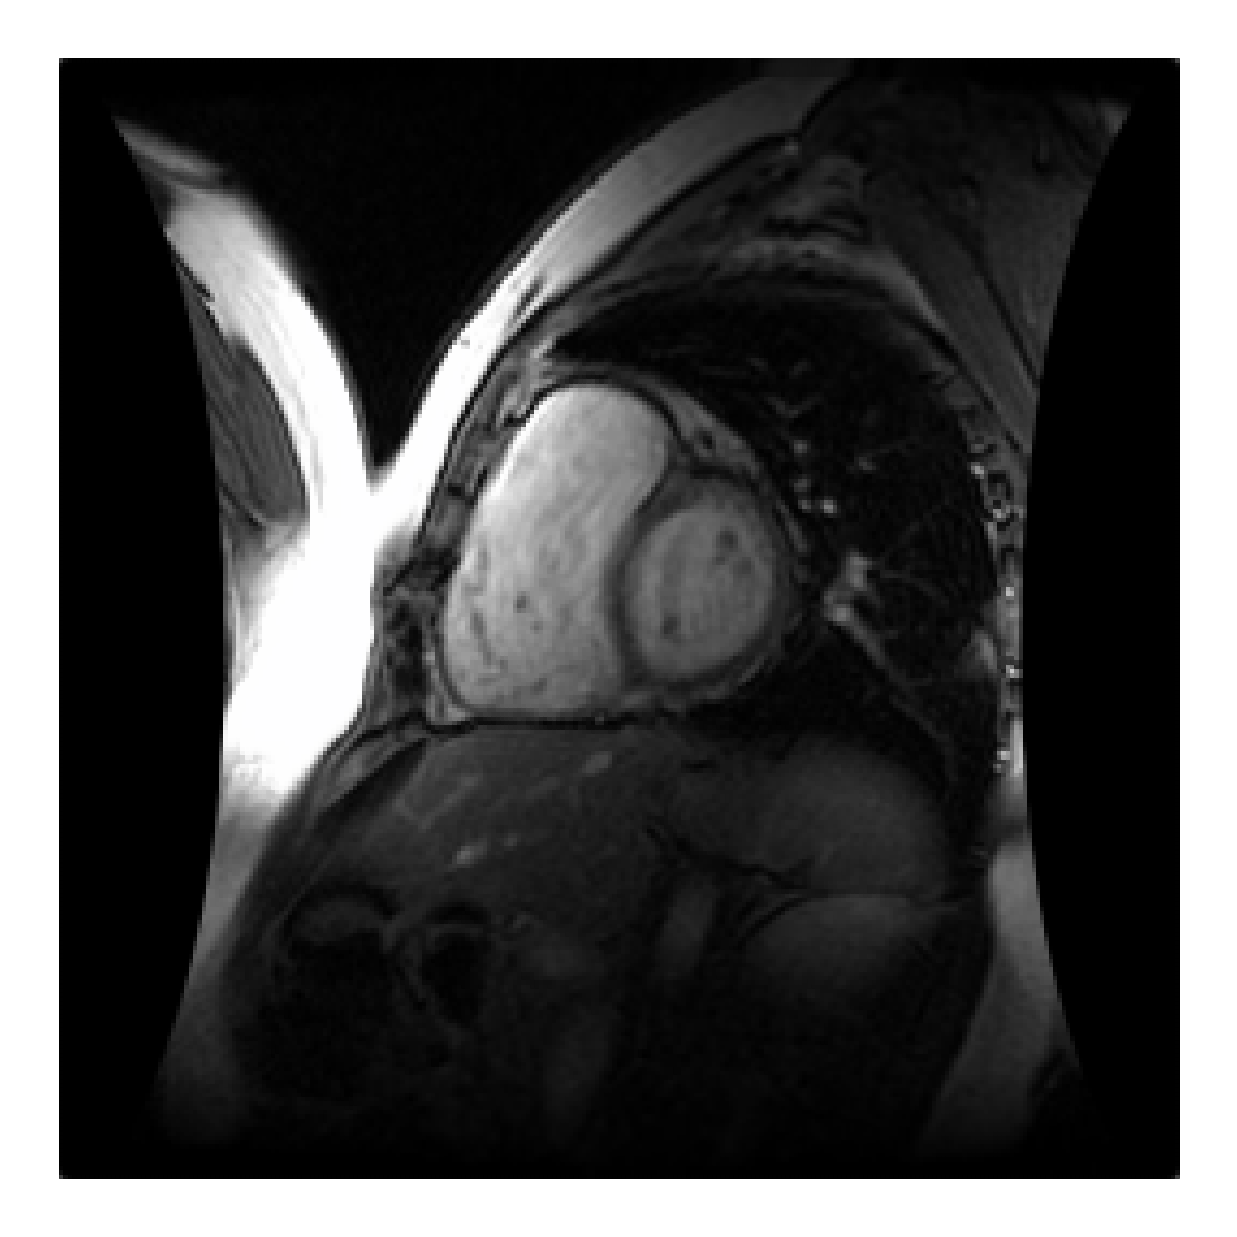

In [4]:
# 
def draw_grid(G, arr=None, ax=None):
    """[summary]

    Args:
        G ([type]): [description]
        arr ([type], optional): [channel last tensor]. Defaults to None.
        ax ([type], optional): [description]. Defaults to None.
    """
    assert len(G) == len(arr.mean(axis=-1).flatten())
    pos = dict(zip(G,G))
    width, height = arr.shape[:2]
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    else:
        fig = None
    
    node_color = []
    node_label = {}
    for n, node in enumerate(G):
        #node_color.append(G.nodes[k].get('color', 'green'))
        y = n // width
        x = n % width
        node_color.append(arr[y,x,:]) if arr is not None else 1
        node_label[node] = G.nodes[node].get('label', n)

    edge_color = []
    edge_width = []
    for edge in G.edges():
        edge_color.append(G.edges[edge].get('color', 'blue'))
        edge_width.append(G.edges[edge].get('width', 1))

    nx.draw_networkx_edges(G, pos=pos, edge_color=edge_color, alpha=0.50, ax=ax, width=edge_width)
    nx.draw_networkx_nodes(G, pos=pos, node_color=node_color, alpha=0.75, ax=ax, node_shape='s', node_size=100)
    fig.tight_layout()
    ax.margins(0.0)
    ax.axis('off')
    ax.autoscale()

draw_grid(image_grid.graph, arr=np.rot90(image_grid.array, -1), ax=None)

In [5]:
display(len(image_grid.graph))
display(len(image_grid.array.flatten()))

65536

65536